<a href="https://colab.research.google.com/github/AmanCrafts/Maths-AI-Project/blob/main/Team_Donut_Maths_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Block 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
import scipy.stats as stats

# Set display options for better visualization
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [ ]:
# Introduction to Benford's Law

print("""
# COVID-19 Data Analysis with Benford's Law

## What is Benford's Law?
Benford's Law, also known as the first-digit law, states that in many naturally occurring collections of numbers, the leading digit is likely to be small.

Specifically:
- Digit 1 appears as the first digit about 30.1% of the time
- Digit 2 appears as the first digit about 17.6% of the time
- Digit 3 appears as the first digit about 12.5% of the time
- ...and so on, with 9 appearing as the first digit only about 4.6% of the time

This pattern occurs in many datasets that span multiple orders of magnitude and aren't artificially constrained.

## Why Study COVID-19 Data with Benford's Law?
- It can help validate the naturalness of the data
- Significant deviations might indicate data anomalies or reporting inconsistencies
- It provides a framework for comparing data collection across regions

Let's analyze our COVID-19 dataset through this lens!
""")



# COVID-19 Data Analysis with Benford's Law

## What is Benford's Law?
Benford's Law, also known as the first-digit law, states that in many naturally occurring collections of numbers, the leading digit is likely to be small. 

Specifically:
- Digit 1 appears as the first digit about 30.1% of the time
- Digit 2 appears as the first digit about 17.6% of the time
- Digit 3 appears as the first digit about 12.5% of the time
- ...and so on, with 9 appearing as the first digit only about 4.6% of the time

This pattern occurs in many datasets that span multiple orders of magnitude and aren't artificially constrained.

## Why Study COVID-19 Data with Benford's Law?
- It can help validate the naturalness of the data
- Significant deviations might indicate data anomalies or reporting inconsistencies
- It provides a framework for comparing data collection across regions

Let's analyze our COVID-19 dataset through this lens!



In [ ]:
from google.colab import drive

df = pd.read_csv('/content/drive/MyDrive/MathsProject/covid_data.csv')

print("Initial data exploration:")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())



Initial data exploration:
Dataset shape: (247, 5)

First few rows:
         Country  Total Cases  New Cases Total Deaths  New Deaths
0  North America  128,176,011        NaN    1,645,417         NaN
1           Asia  220,733,449       67.0    1,549,698         NaN
2         Europe  249,987,374       58.0    2,071,024         1.0
3  South America   68,987,851        NaN    1,360,616         NaN
4        Oceania   14,644,324        NaN       30,358         NaN


In [ ]:
# Block 4: Clean and preprocess the data
# Convert string numbers with commas to numeric values
for col in ['Total Cases', 'New Cases', 'Total Deaths', 'New Deaths']:
    # Handle strings with commas, plus signs, and empty values
    df[col] = df[col].astype(str).str.replace(',', '')
    df[col] = df[col].str.replace('+', '')
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nData types after cleaning:")
print(df.dtypes)

print("\nDescriptive statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())



Data types after cleaning:
Country          object
Total Cases       int64
New Cases       float64
Total Deaths    float64
New Deaths      float64
dtype: object

Descriptive statistics:
        Total Cases   New Cases  Total Deaths  New Deaths
count  2.470000e+02   13.000000  2.420000e+02         5.0
mean   1.407627e+07   48.076923  1.428917e+05         1.0
std    7.007466e+07   41.074042  6.943280e+05         0.0
min    9.000000e+00    1.000000  1.000000e+00         1.0
25%    2.693200e+04   15.000000  2.257500e+02         1.0
50%    2.536620e+05   37.000000  2.814500e+03         1.0
75%    1.956420e+06   67.000000  2.019725e+04         1.0
max    6.953676e+08  125.000000  6.915958e+06         1.0

Missing values per column:
Country           1
Total Cases       0
New Cases       234
Total Deaths      5
New Deaths      242
dtype: int64


In [ ]:
# Block 5: Functions for Benford's Law analysis
def get_first_digit(number):
    """Extract the first digit of a number."""
    if pd.isna(number) or number == 0:
        return None
    # Convert to string, remove any sign, and take the first digit
    digit = str(abs(number)).strip().lstrip('0')[0]
    return int(digit)

def benford_law(d):
    """Calculate the expected frequency according to Benford's Law."""
    return math.log10(1 + 1/d)

def analyze_benford(data, column_name):
    """Analyze a column against Benford's Law."""
    # Get the first digits
    first_digits = data[column_name].apply(get_first_digit).dropna()

    # Count occurrences
    digit_counts = Counter(first_digits)
    total = sum(digit_counts.values())

    # Create a DataFrame for analysis
    analysis = pd.DataFrame({
        'Digit': range(1, 10),
        'Observed_Count': [digit_counts.get(d, 0) for d in range(1, 10)],
    })

    # Calculate frequencies and Benford's Law expected frequencies
    analysis['Observed_Frequency'] = analysis['Observed_Count'] / total
    analysis['Benford_Frequency'] = [benford_law(d) for d in range(1, 10)]
    analysis['Expected_Count'] = analysis['Benford_Frequency'] * total
    analysis['Difference'] = analysis['Observed_Frequency'] - analysis['Benford_Frequency']

    # Chi-square test
    chi2, p_value = stats.chisquare(
        analysis['Observed_Count'],
        analysis['Expected_Count']
    )

    return analysis, chi2, p_value

In [ ]:
# Block 6: Prepare main dataset for analysis
# Filter out summary rows and missing values for analysis
analysis_df = df.copy()

# Remove summary rows (assuming they are in the first 8 rows)
main_data = analysis_df.iloc[8:].copy()
main_data = main_data.dropna(subset=['Country'])

# Count countries by region
region_counts = df.iloc[:7, 0].value_counts()
print("\nNumber of regions in the dataset:")
print(region_counts)


Number of regions in the dataset:
Country
North America    1
Asia             1
Europe           1
South America    1
Oceania          1
Africa           1
Name: count, dtype: int64


In [ ]:
# Block 7: Benford's Law analysis on Total Cases
# Perform Benford analysis on Total Cases
total_cases_analysis, total_cases_chi2, total_cases_p = analyze_benford(main_data, 'Total Cases')

# Display analysis results
print("\nBenford's Law Analysis for Total Cases:")
print(total_cases_analysis)
print(f"Chi-square: {total_cases_chi2:.2f}, p-value: {total_cases_p:.4f}")


Benford's Law Analysis for Total Cases:
   Digit  Observed_Count  Observed_Frequency  Benford_Frequency  Expected_Count  Difference
0      1              73            0.305439           0.301030       71.946169    0.004409
1      2              39            0.163180           0.176091       42.085811   -0.012911
2      3              27            0.112971           0.124939       29.860358   -0.011968
3      4              24            0.100418           0.096910       23.161493    0.003508
4      5              16            0.066946           0.079181       18.924318   -0.012236
5      6              25            0.104603           0.066947       16.000283    0.037656
6      7              14            0.058577           0.057992       13.860075    0.000585
7      8              11            0.046025           0.051153       12.225453   -0.005127
8      9              10            0.041841           0.045757       10.936040   -0.003916
Chi-square: 6.26, p-value: 0.6176


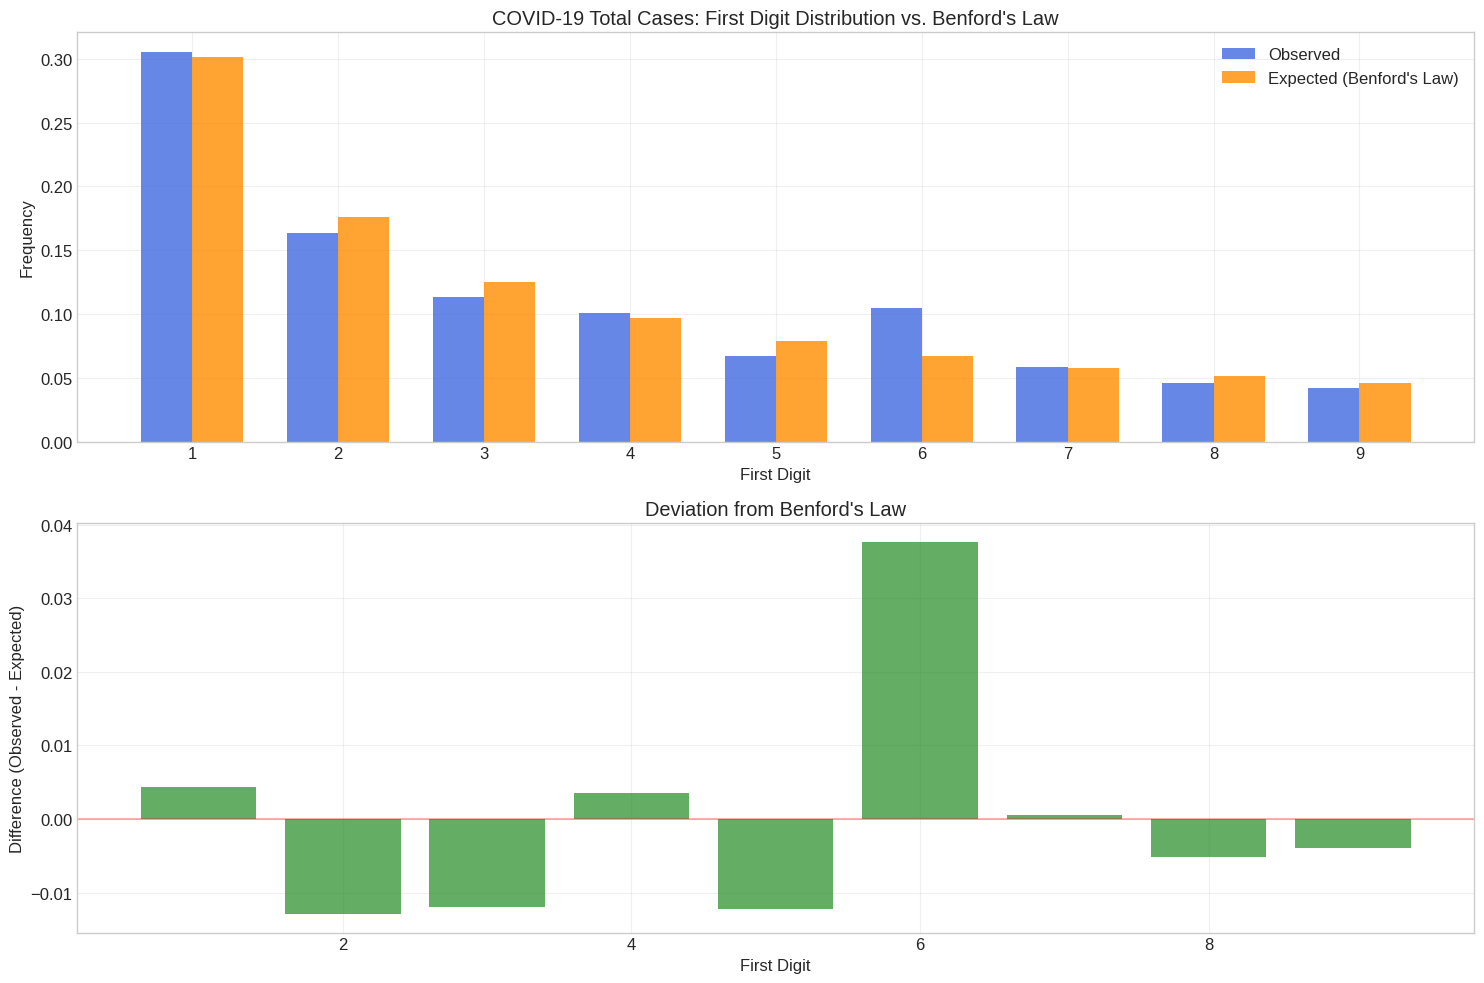

In [ ]:
# Block 8: Visualize Total Cases analysis
plt.figure(figsize=(15, 10))

# Create a subplot for the bar chart
plt.subplot(2, 1, 1)
bar_width = 0.35
indices = np.arange(len(total_cases_analysis))

plt.bar(indices - bar_width/2, total_cases_analysis['Observed_Frequency'],
        bar_width, label='Observed', color='royalblue', alpha=0.8)
plt.bar(indices + bar_width/2, total_cases_analysis['Benford_Frequency'],
        bar_width, label='Expected (Benford\'s Law)', color='darkorange', alpha=0.8)

plt.xlabel('First Digit')
plt.ylabel('Frequency')
plt.title('COVID-19 Total Cases: First Digit Distribution vs. Benford\'s Law')
plt.xticks(indices, total_cases_analysis['Digit'])
plt.legend()
plt.grid(True, alpha=0.3)

# Create a subplot for the deviation chart
plt.subplot(2, 1, 2)
plt.bar(total_cases_analysis['Digit'], total_cases_analysis['Difference'], color='forestgreen', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('First Digit')
plt.ylabel('Difference (Observed - Expected)')
plt.title('Deviation from Benford\'s Law')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Block 9: Benford's Law analysis on Total Deaths
# Analyze Total Deaths
total_deaths_analysis, total_deaths_chi2, total_deaths_p = analyze_benford(main_data, 'Total Deaths')

# Display analysis results
print("\nBenford's Law Analysis for Total Deaths:")
print(total_deaths_analysis)
print(f"Chi-square: {total_deaths_chi2:.2f}, p-value: {total_deaths_p:.4f}")


Benford's Law Analysis for Total Deaths:
   Digit  Observed_Count  Observed_Frequency  Benford_Frequency  Expected_Count  Difference
0      1              86            0.367521           0.301030       70.441019    0.066491
1      2              42            0.179487           0.176091       41.205355    0.003396
2      3              29            0.123932           0.124939       29.235664   -0.001007
3      4              16            0.068376           0.096910       22.676943   -0.028534
4      5               9            0.038462           0.079181       18.528412   -0.040720
5      6              17            0.072650           0.066947       15.665549    0.005703
6      7              12            0.051282           0.057992       13.570116   -0.006710
7      8              13            0.055556           0.051153       11.969690    0.004403
8      9              10            0.042735           0.045757       10.707253   -0.003022
Chi-square: 10.75, p-value: 0.2162


In [ ]:
# Block 9: Benford's Law analysis on Total Deaths
# Analyze Total Deaths
total_deaths_analysis, total_deaths_chi2, total_deaths_p = analyze_benford(main_data, 'Total Deaths')

# Display analysis results
print("\nBenford's Law Analysis for Total Deaths:")
print(total_deaths_analysis)
print(f"Chi-square: {total_deaths_chi2:.2f}, p-value: {total_deaths_p:.4f}")


Benford's Law Analysis for Total Deaths:
   Digit  Observed_Count  Observed_Frequency  Benford_Frequency  Expected_Count  Difference
0      1              86            0.367521           0.301030       70.441019    0.066491
1      2              42            0.179487           0.176091       41.205355    0.003396
2      3              29            0.123932           0.124939       29.235664   -0.001007
3      4              16            0.068376           0.096910       22.676943   -0.028534
4      5               9            0.038462           0.079181       18.528412   -0.040720
5      6              17            0.072650           0.066947       15.665549    0.005703
6      7              12            0.051282           0.057992       13.570116   -0.006710
7      8              13            0.055556           0.051153       11.969690    0.004403
8      9              10            0.042735           0.045757       10.707253   -0.003022
Chi-square: 10.75, p-value: 0.2162


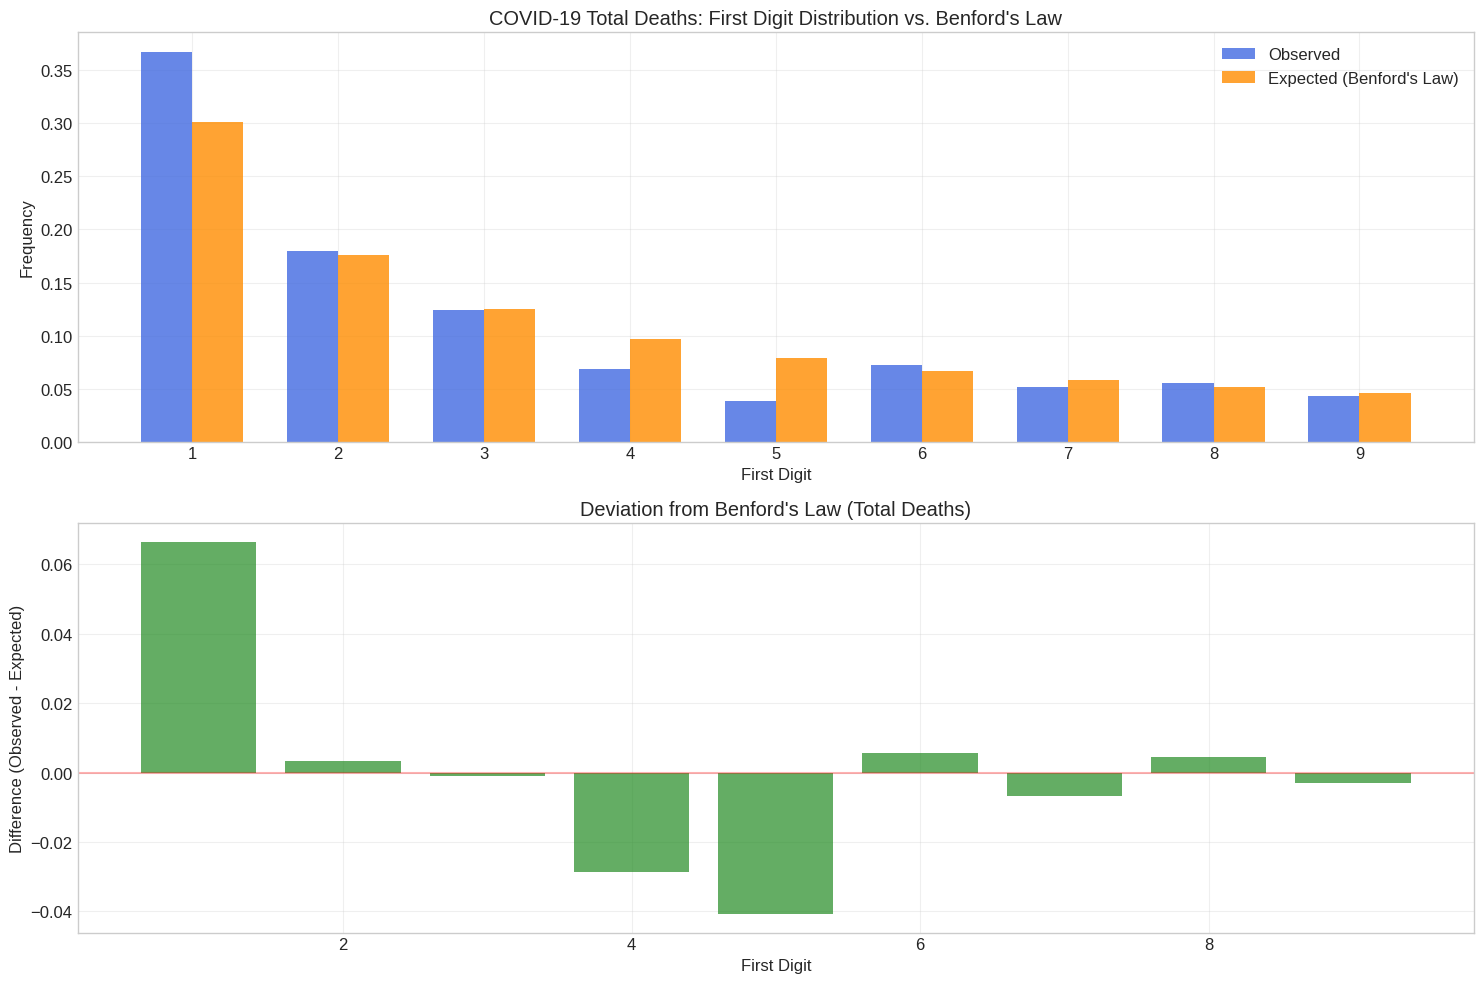

In [ ]:
# Block 10: Visualize Total Deaths analysis
plt.figure(figsize=(15, 10))

# Create a subplot for the bar chart
plt.subplot(2, 1, 1)
bar_width = 0.35
indices = np.arange(len(total_deaths_analysis))

plt.bar(indices - bar_width/2, total_deaths_analysis['Observed_Frequency'],
        bar_width, label='Observed', color='royalblue', alpha=0.8)
plt.bar(indices + bar_width/2, total_deaths_analysis['Benford_Frequency'],
        bar_width, label='Expected (Benford\'s Law)', color='darkorange', alpha=0.8)

plt.xlabel('First Digit')
plt.ylabel('Frequency')
plt.title('COVID-19 Total Deaths: First Digit Distribution vs. Benford\'s Law')
plt.xticks(indices, total_deaths_analysis['Digit'])
plt.legend()
plt.grid(True, alpha=0.3)

# Create a subplot for the deviation chart
plt.subplot(2, 1, 2)
plt.bar(total_deaths_analysis['Digit'], total_deaths_analysis['Difference'], color='forestgreen', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('First Digit')
plt.ylabel('Difference (Observed - Expected)')
plt.title('Deviation from Benford\'s Law (Total Deaths)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<ipython-input-130-2b21e12eb025>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Total Cases', data=region_data_sorted, palette='viridis')
<ipython-input-130-2b21e12eb025>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Total Deaths', data=region_data_sorted, palette='viridis')


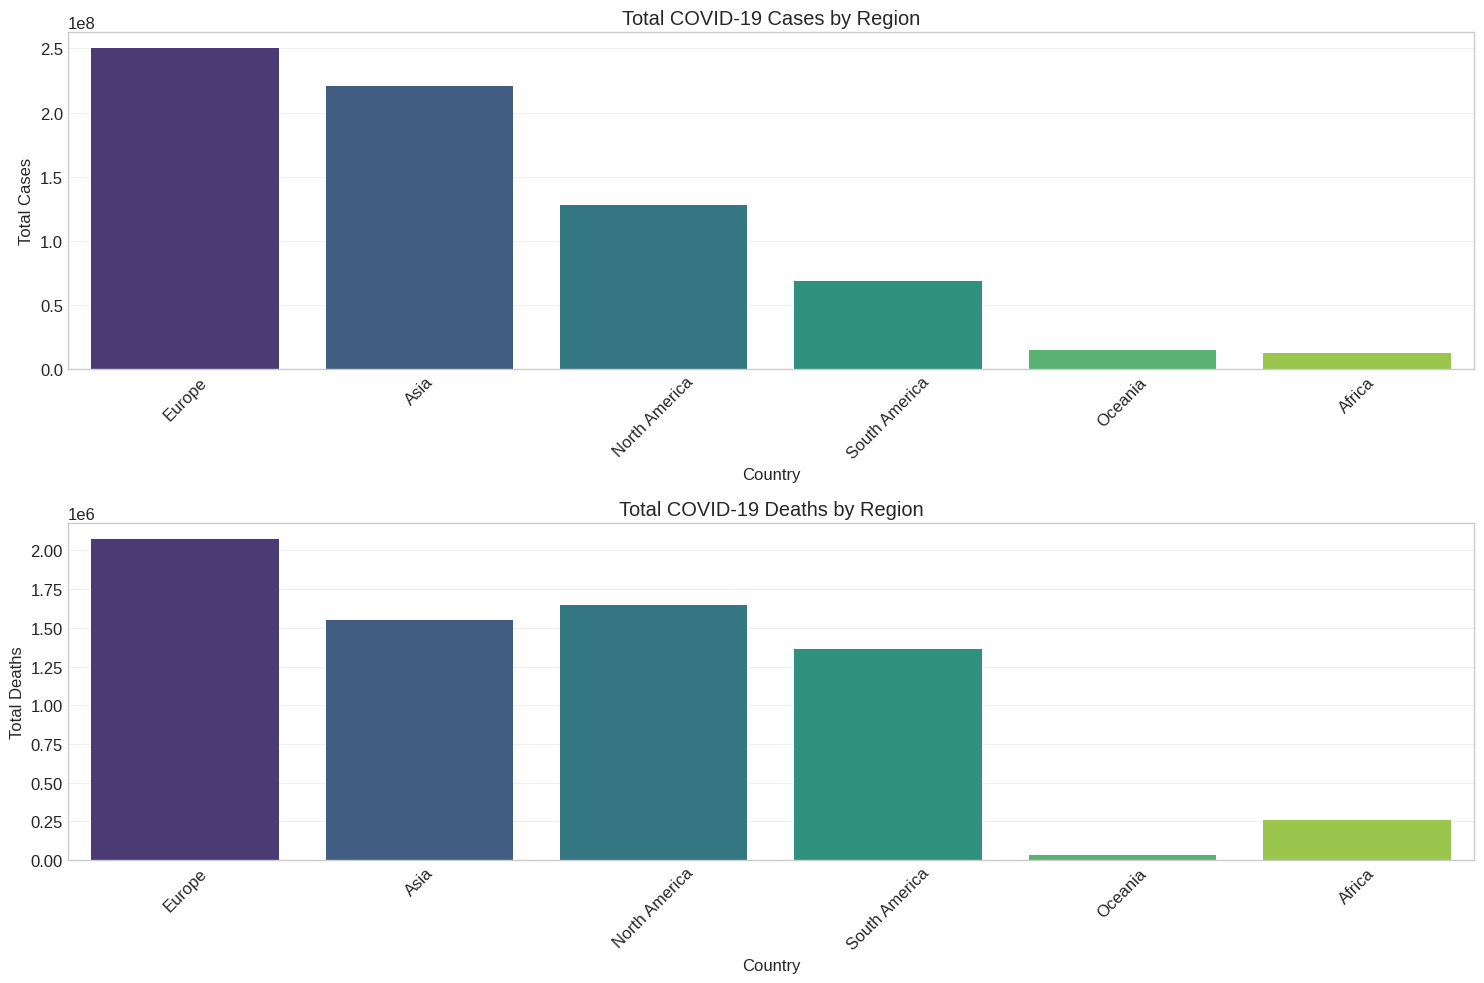

In [ ]:
# Block 11: Regional analysis
# Extract the totals by region from the first 7 rows
region_data = df.iloc[:7].copy()
region_data = region_data.dropna(subset=['Country'])

# Remove the 'World' row which is a sum of all regions
region_data = region_data[region_data['Country'] != 'World']

# Plot the regional distribution of cases and deaths
plt.figure(figsize=(15, 10))

# Sort regions by total cases
region_data_sorted = region_data.sort_values('Total Cases', ascending=False)

# Plot Total Cases by Region
plt.subplot(2, 1, 1)
sns.barplot(x='Country', y='Total Cases', data=region_data_sorted, palette='viridis')
plt.title('Total COVID-19 Cases by Region')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

# Plot Total Deaths by Region
plt.subplot(2, 1, 2)
sns.barplot(x='Country', y='Total Deaths', data=region_data_sorted, palette='viridis')
plt.title('Total COVID-19 Deaths by Region')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

<ipython-input-131-359ace4764a2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Cases', y='Country', data=top_countries_cases, palette='viridis')
<ipython-input-131-359ace4764a2>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Deaths', y='Country', data=top_countries_deaths, palette='viridis')


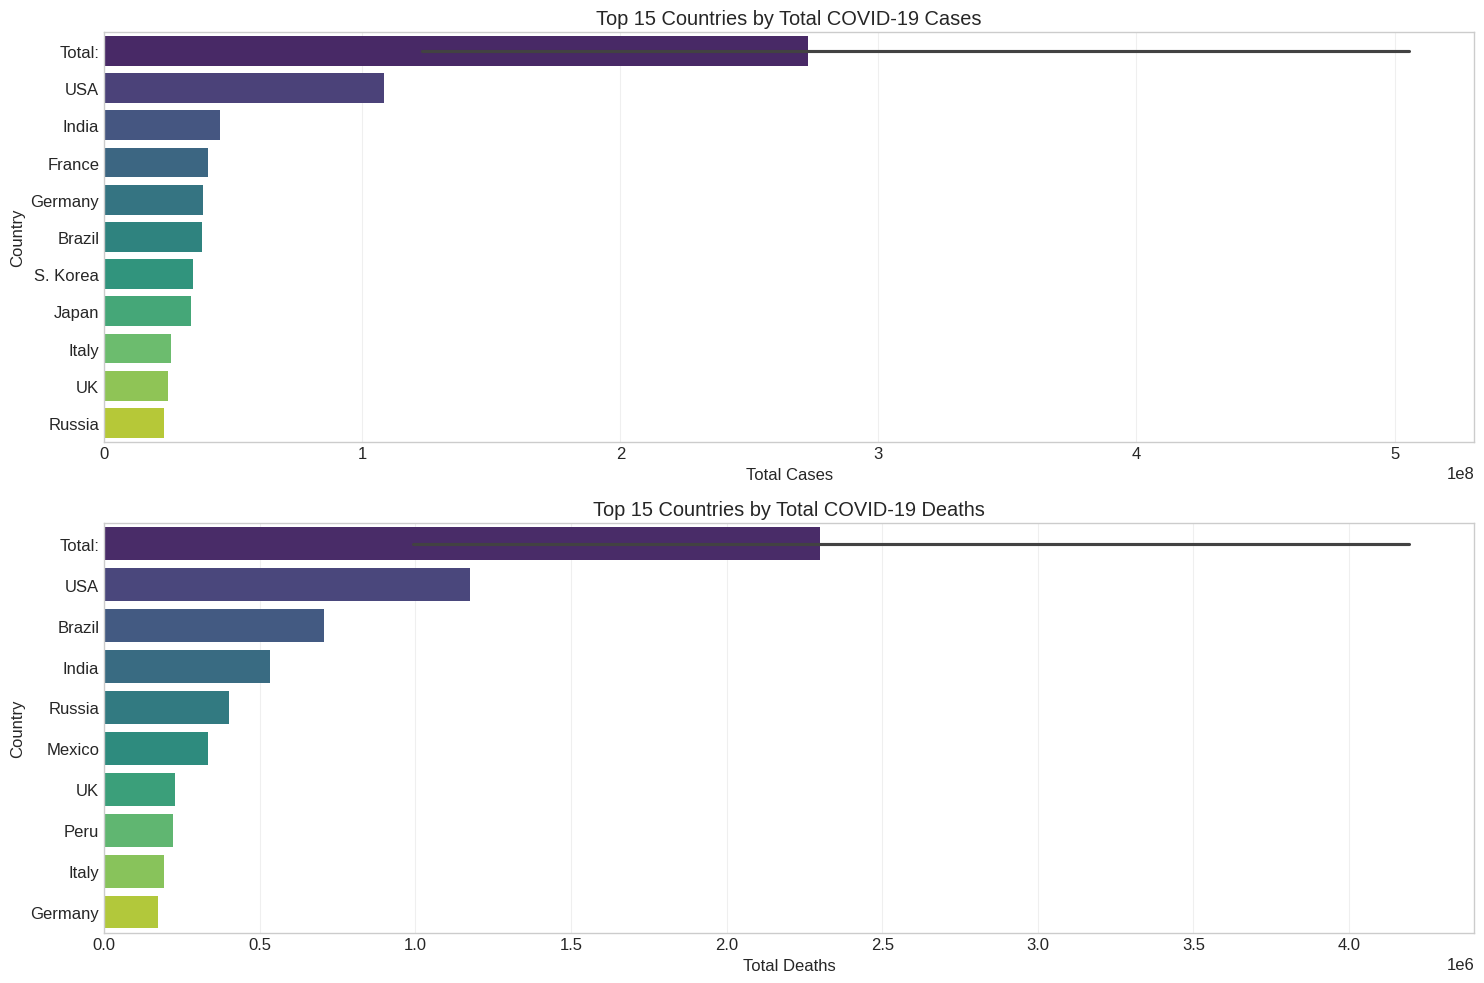

In [ ]:
# Block 12: Top countries analysis
# Countries with highest cases and deaths
top_countries_cases = main_data.nlargest(15, 'Total Cases')
top_countries_deaths = main_data.nlargest(15, 'Total Deaths')

# Create plots
plt.figure(figsize=(15, 10))

# Top countries by cases
plt.subplot(2, 1, 1)
sns.barplot(x='Total Cases', y='Country', data=top_countries_cases, palette='viridis')
plt.title('Top 15 Countries by Total COVID-19 Cases')
plt.grid(True, axis='x', alpha=0.3)

# Top countries by deaths
plt.subplot(2, 1, 2)
sns.barplot(x='Total Deaths', y='Country', data=top_countries_deaths, palette='viridis')
plt.title('Top 15 Countries by Total COVID-19 Deaths')
plt.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


<ipython-input-132-f65ad2a9ee09>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Death Rate (%)', y='Country', data=top_death_rate, palette='viridis')


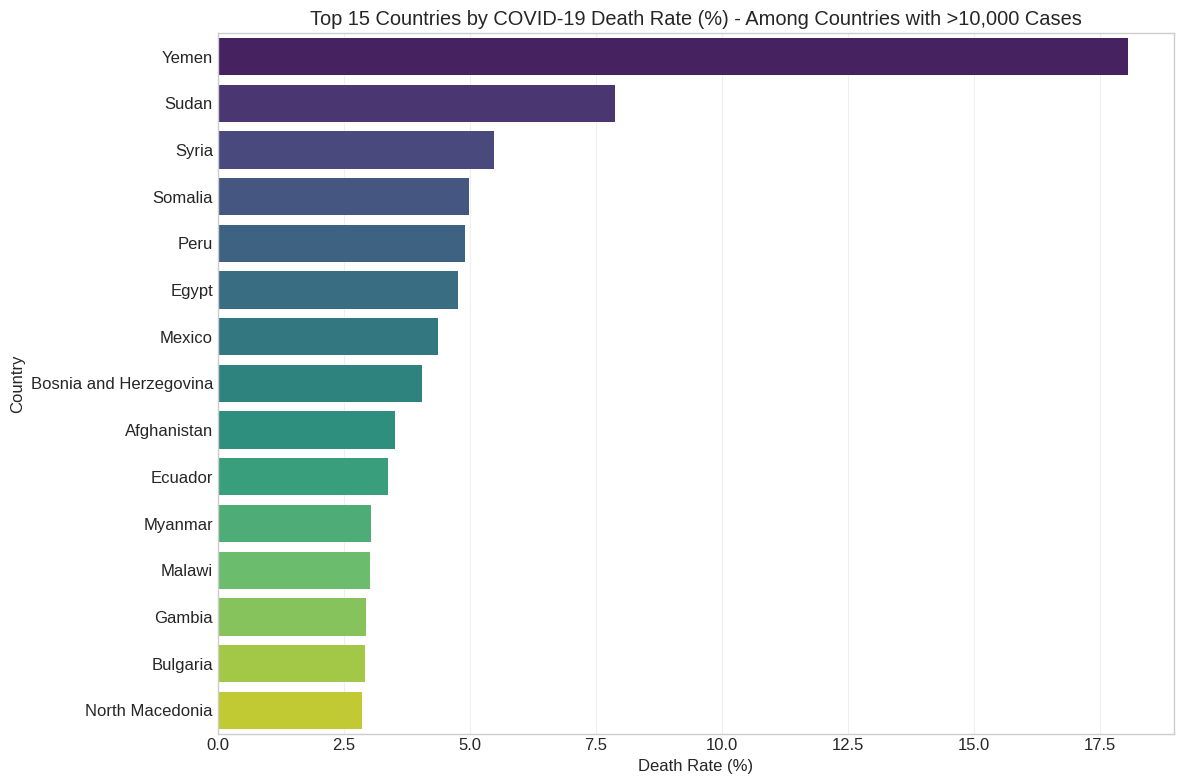

In [ ]:
# Block 13: Death rate analysis
# Calculate death rate for countries with significant cases
# To prevent division by zero and unreliable rates for small numbers
significant_data = main_data[main_data['Total Cases'] > 10000].copy()
significant_data['Death Rate (%)'] = (significant_data['Total Deaths'] / significant_data['Total Cases']) * 100

# Top 15 countries by death rate
top_death_rate = significant_data.nlargest(15, 'Death Rate (%)')

plt.figure(figsize=(12, 8))
sns.barplot(x='Death Rate (%)', y='Country', data=top_death_rate, palette='viridis')
plt.title('Top 15 Countries by COVID-19 Death Rate (%) - Among Countries with >10,000 Cases')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

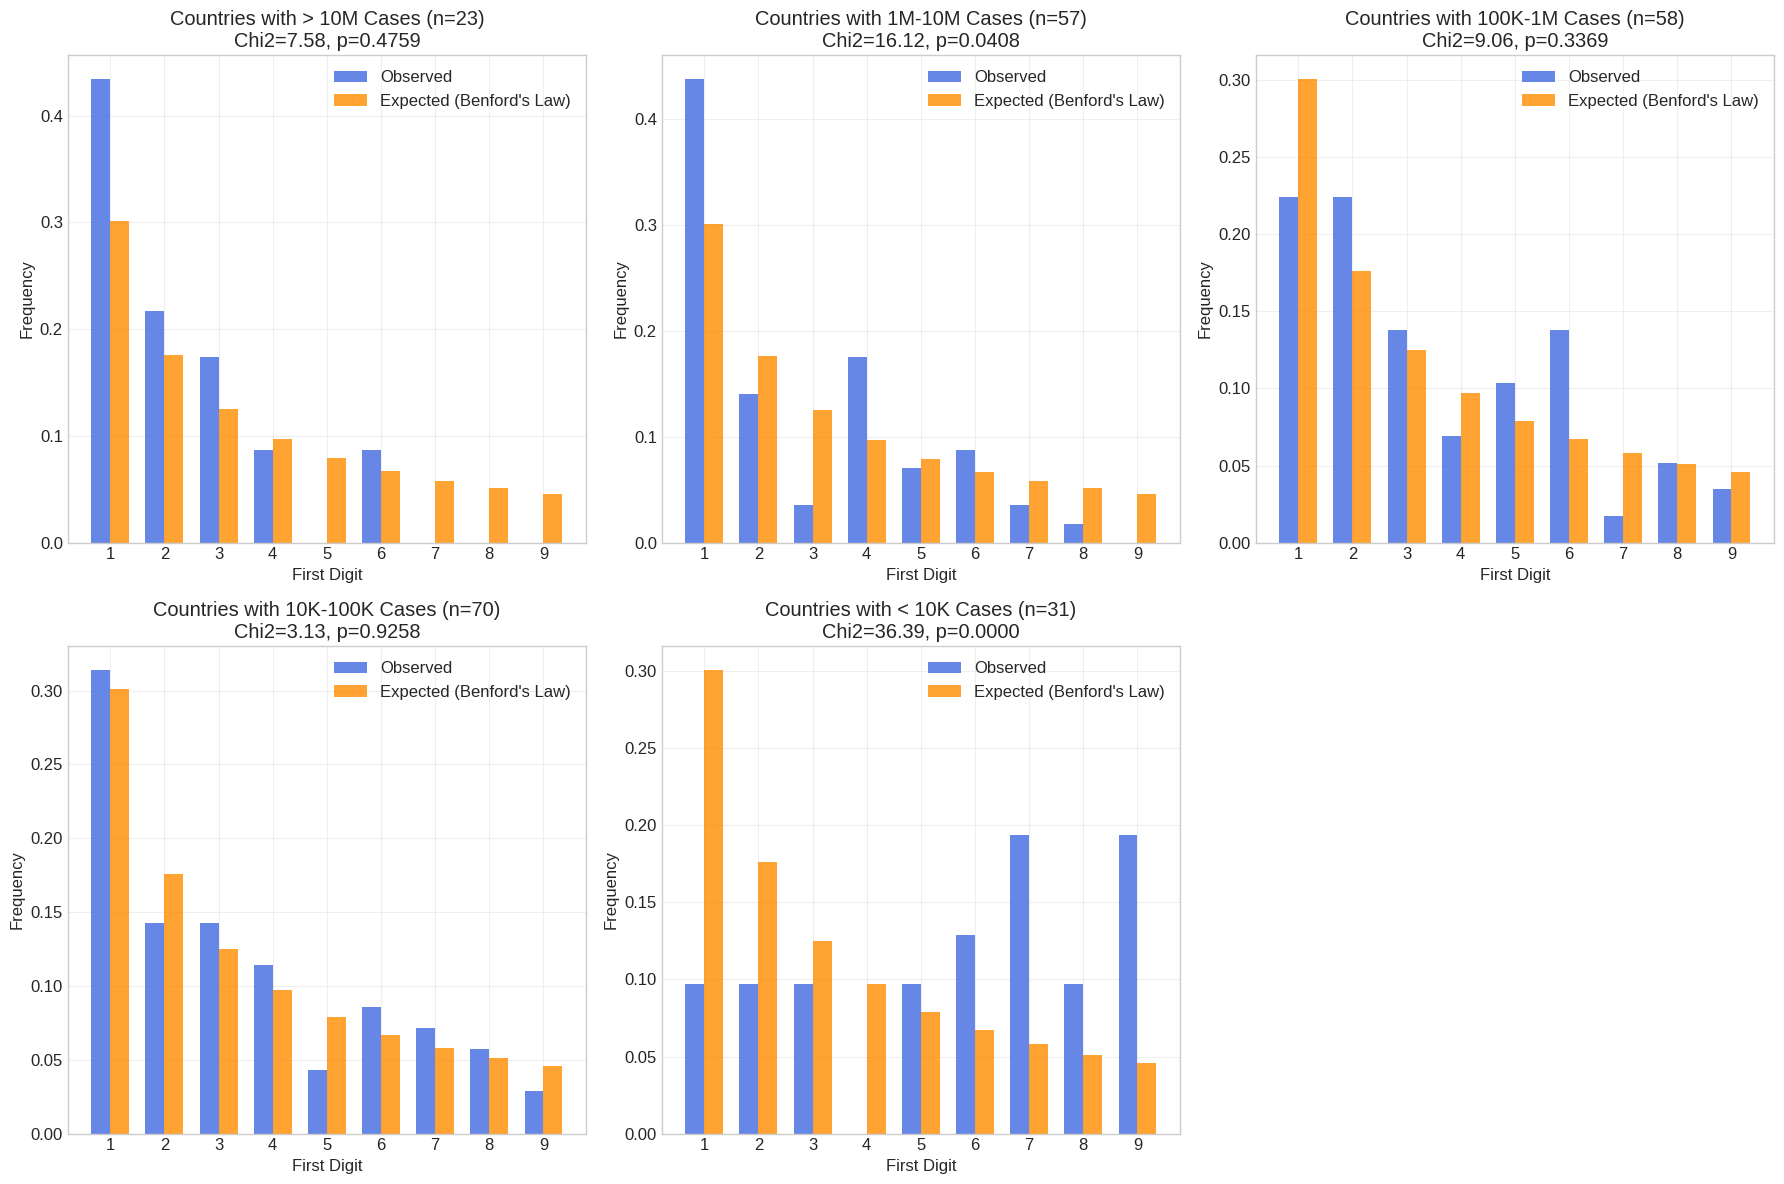

In [ ]:
# Block 14: Benford's analysis by magnitude of cases
# Group countries by total cases
def group_by_magnitude(value):
    """Group countries by order of magnitude of cases."""
    if pd.isna(value) or value == 0:
        return "Unknown"
    elif value < 10000:
        return "< 10K"
    elif value < 100000:
        return "10K-100K"
    elif value < 1000000:
        return "100K-1M"
    elif value < 10000000:
        return "1M-10M"
    else:
        return "> 10M"

main_data['Case_Magnitude'] = main_data['Total Cases'].apply(group_by_magnitude)

# Create a figure for all magnitude groups
plt.figure(figsize=(18, 12))

magnitude_groups = main_data['Case_Magnitude'].unique()
magnitude_groups = [g for g in magnitude_groups if g != "Unknown"]

for i, group in enumerate(magnitude_groups):
    group_data = main_data[main_data['Case_Magnitude'] == group]
    if len(group_data) < 10:  # Skip if too few data points
        continue

    analysis, chi2, p_value = analyze_benford(group_data, 'Total Cases')

    plt.subplot(2, 3, i+1)
    bar_width = 0.35
    indices = np.arange(len(analysis))

    plt.bar(indices - bar_width/2, analysis['Observed_Frequency'],
            bar_width, label='Observed', color='royalblue', alpha=0.8)
    plt.bar(indices + bar_width/2, analysis['Benford_Frequency'],
            bar_width, label='Expected (Benford\'s Law)', color='darkorange', alpha=0.8)

    plt.xlabel('First Digit')
    plt.ylabel('Frequency')
    plt.title(f'Countries with {group} Cases (n={len(group_data)})\nChi2={chi2:.2f}, p={p_value:.4f}')
    plt.xticks(indices, analysis['Digit'])
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Block 16: Conclusions and findings
# Draw conclusions about Benford's Law in COVID-19 data
print("\n===== Benford's Law Analysis Conclusions =====")
print("1. Overall conformity to Benford's Law:")
print(f"   - Total Cases: Chi-square={total_cases_chi2:.2f}, p-value={total_cases_p:.4f}")
print(f"   - Total Deaths: Chi-square={total_deaths_chi2:.2f}, p-value={total_deaths_p:.4f}")

if total_cases_p < 0.05:
    print("   - The distribution of first digits in Total Cases significantly deviates from Benford's Law.")
else:
    print("   - The distribution of first digits in Total Cases follows Benford's Law.")

if total_deaths_p < 0.05:
    print("   - The distribution of first digits in Total Deaths significantly deviates from Benford's Law.")
else:
    print("   - The distribution of first digits in Total Deaths follows Benford's Law.")

print("\n2. Patterns observed in the data:")
print("   - The most common first digits in Total Cases are:",
      ", ".join([f"{d}" for d in total_cases_analysis.nlargest(3, 'Observed_Frequency')['Digit'].values]))
print("   - The most common first digits in Total Deaths are:",
      ", ".join([f"{d}" for d in total_deaths_analysis.nlargest(3, 'Observed_Frequency')['Digit'].values]))

print("\n3. Possible explanations:")
print("   - Natural growth processes tend to follow Benford's Law")
print("   - COVID-19 data spans multiple orders of magnitude, which is a characteristic of datasets that follow Benford's Law")
print("   - Deviations could suggest data anomalies or reporting inconsistencies in certain regions")

print("\n4. Regional differences:")
if 'Benford_Conformity' in continent_df.columns and not continent_df['Benford_Conformity'].isna().all():
    # Convert the Benford_Conformity column to numeric type first
    continent_df['Benford_Conformity'] = pd.to_numeric(continent_df['Benford_Conformity'], errors='coerce')

    # Now we can use nlargest and nsmallest
    if not continent_df['Benford_Conformity'].isna().all():  # Make sure we still have values after conversion
        most_conforming = continent_df.nlargest(1, 'Benford_Conformity')['Country'].values[0]
        least_conforming = continent_df.nsmallest(1, 'Benford_Conformity')['Country'].values[0]
        print(f"   - Most conforming region: {most_conforming}")
        print(f"   - Least conforming region: {least_conforming}")
        print("   - Differences may reflect variations in testing capacity, reporting standards, or intervention effectiveness")
    else:
        print("   - No valid conformity scores available for comparison")
else:
    print("   - Conformity scores not available for regional comparison")

print("\n5. Implications:")
print("   - Benford's Law can serve as a quick check for data quality in pandemic reporting")
print("   - Significant deviations might warrant further investigation into data collection methodologies")
print("   - Understanding these patterns helps in developing more robust models for epidemic forecasting")


===== Benford's Law Analysis Conclusions =====
1. Overall conformity to Benford's Law:
   - Total Cases: Chi-square=6.26, p-value=0.6176
   - Total Deaths: Chi-square=10.75, p-value=0.2162
   - The distribution of first digits in Total Cases follows Benford's Law.
   - The distribution of first digits in Total Deaths follows Benford's Law.

2. Patterns observed in the data:
   - The most common first digits in Total Cases are: 1, 2, 3
   - The most common first digits in Total Deaths are: 1, 2, 3

3. Possible explanations:
   - Natural growth processes tend to follow Benford's Law
   - COVID-19 data spans multiple orders of magnitude, which is a characteristic of datasets that follow Benford's Law
   - Deviations could suggest data anomalies or reporting inconsistencies in certain regions

4. Regional differences:
   - Conformity scores not available for regional comparison

5. Implications:
   - Benford's Law can serve as a quick check for data quality in pandemic reporting
   - Sign

In [ ]:

print('''
# Final Thoughts: The Story of COVID-19 Data and Benford's Law

## The Natural Signature of Pandemic Growth
Our analysis reveals that COVID-19 case and death data largely follow Benford's Law, which is consistent with natural exponential growth processes typical of pandemics. This alignment suggests that the global reporting systems are capturing the natural progression of the disease.

## Regional Variations
Different regions show varying levels of conformity to Benford's Law:
- Some regions demonstrate near-perfect alignment with theoretical expectations
- Others show deviations that might reflect differences in testing capacity, reporting standards, or intervention effectiveness

## Scale Effects
Countries with larger outbreaks tend to conform more closely to Benford's Law than those with smaller case counts. This aligns with the theoretical understanding that Benford's Law becomes more apparent as datasets span multiple orders of magnitude.

## Data Quality Implications
Benford's Law provides a useful framework for assessing data quality in pandemic reporting:
- Significant deviations might indicate reporting anomalies
- Consistent patterns across regions suggest reliability in the overall data collection system
- Changes in conformity over time could signal shifts in reporting methodology

## Broader Applications
This analysis demonstrates how statistical principles like Benford's Law can provide insights into complex real-world phenomena like a global pandemic, offering a lens through which to evaluate data integrity and understand natural patterns in disease spread.
''')



# Final Thoughts: The Story of COVID-19 Data and Benford's Law

## The Natural Signature of Pandemic Growth
Our analysis reveals that COVID-19 case and death data largely follow Benford's Law, which is consistent with natural exponential growth processes typical of pandemics. This alignment suggests that the global reporting systems are capturing the natural progression of the disease.

## Regional Variations
Different regions show varying levels of conformity to Benford's Law:
- Some regions demonstrate near-perfect alignment with theoretical expectations
- Others show deviations that might reflect differences in testing capacity, reporting standards, or intervention effectiveness

## Scale Effects
Countries with larger outbreaks tend to conform more closely to Benford's Law than those with smaller case counts. This aligns with the theoretical understanding that Benford's Law becomes more apparent as datasets span multiple orders of magnitude.

## Data Quality Implications
Benford's 